# Validation Check

In [1]:
# load libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numerapi import NumerAPI

In [2]:
# # get os variables
# import os
# from dotenv import load_dotenv 

# load_dotenv()
# PUBLIC_ID = os.getenv('PUBLIC_ID')
# SECRET_KEY = os.getenv('SECRET_KEY')

In [3]:
# # instantiate api & check for round
# napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)
# current_round = napi.get_current_round()
# print(f"Current round #: {current_round}")

In [4]:
# era corr function
def compute_corr_by_era(val_df, model_list, corr_method):
    df_list = []
    for m in model_list:
        r = val_df.groupby("era")[["target", m]].corr(method=corr_method).iloc[0::2, -1]
        df = pd.DataFrame(r)
        df_list.append(r)
    df_all = pd.concat(df_list, axis=1).dropna().reset_index()
    return df_all.drop("level_1", axis=1).set_index("era")

---
# Load validation datesets

In [5]:
# read validation set
validation = pd.read_parquet('data/validation.parquet', columns=["era", "target"]).dropna()

In [22]:
# file names
file_list = [
    "baseline", "foxhound", "deadcell", "deadcellv2", "cobra", "beautybeast", "skulls", 
    # "desperado", "desperadov2", "desperadov3", 
    "gaia", "gaiav2", "terra", "spira"
]

In [23]:
# join val pred files
val_list = []

for file in file_list:
    df = pd.read_csv(f"predictions/dh_{file}_val_preds.csv").set_index("id")
    val_list.append(df)

val = pd.concat(val_list, axis=1, join="inner")
val.columns = file_list

val.shape

(2314547, 11)

In [24]:
# join together
df = validation.merge(val, left_index=True, right_index=True)

In [25]:
# create averagejoe model
df["averagejoe"] = df["target"].mean() + np.random.rand(len(df.index)) / 100

In [26]:
# view data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2314547 entries, n000101811a8a843 to nffea6de91ea4c7b
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   era          object 
 1   target       float32
 2   baseline     float64
 3   foxhound     float64
 4   deadcell     float64
 5   deadcellv2   float64
 6   cobra        float64
 7   beautybeast  float64
 8   skulls       float64
 9   gaia         float64
 10  gaiav2       float64
 11  terra        float64
 12  spira        float64
 13  averagejoe   float64
dtypes: float32(1), float64(12), object(1)
memory usage: 320.5+ MB


---
# Get correlation by era

In [27]:
# models
lgbm_model_names = ["baseline", "foxhound", "deadcell", "cobra", "beautybeast", "skulls"]
dnn_model_names = ["baseline", "gaia", "gaiav2", "terra", "spira"]
dev_model_names = ["baseline", "deadcellv2", "averagejoe"]

In [28]:
# get corrs
lgbm_pearson_corr = compute_corr_by_era(val_df=df, model_list=lgbm_model_names, corr_method="pearson")
lgbm_spearman_corr = compute_corr_by_era(val_df=df, model_list=lgbm_model_names, corr_method="spearman")

dnn_pearson_corr = compute_corr_by_era(val_df=df, model_list=dnn_model_names, corr_method="pearson")
dnn_spearman_corr = compute_corr_by_era(val_df=df, model_list=dnn_model_names, corr_method="spearman")

dev_pearson_corr = compute_corr_by_era(val_df=df, model_list=dev_model_names, corr_method="pearson")
dev_spearman_corr = compute_corr_by_era(val_df=df, model_list=dev_model_names, corr_method="spearman")

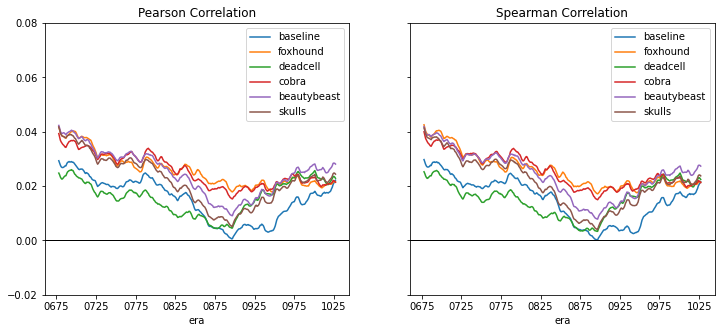

In [29]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
lgbm_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
lgbm_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].axhline(0, color ='black', linewidth=1)
axes[0].set_ylim(-0.02, 0.08)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

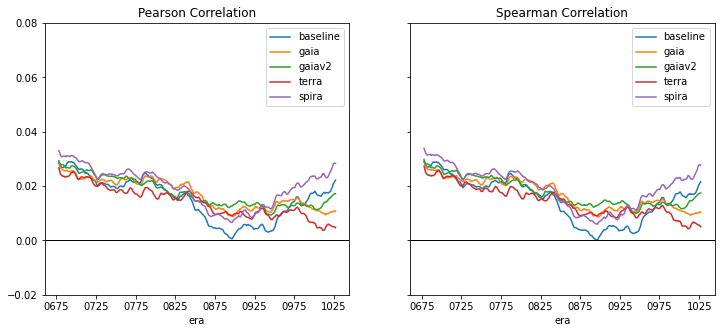

In [30]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
dnn_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
dnn_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].axhline(0, color ='black', linewidth=1)
axes[0].set_ylim(-0.02, 0.08)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

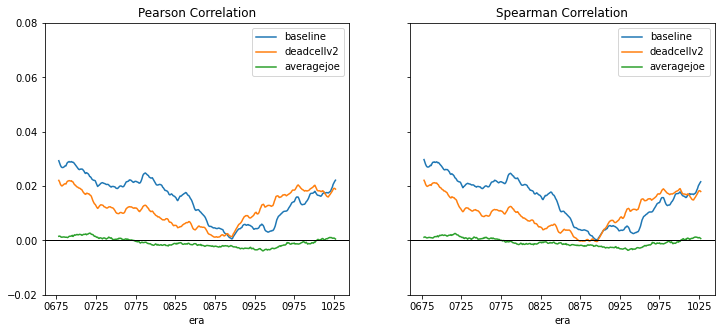

In [31]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
dev_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
dev_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].set_ylim(-0.02, 0.08)
axes[0].axhline(0, color ='black', linewidth=1)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

---
# Net corr scores by models

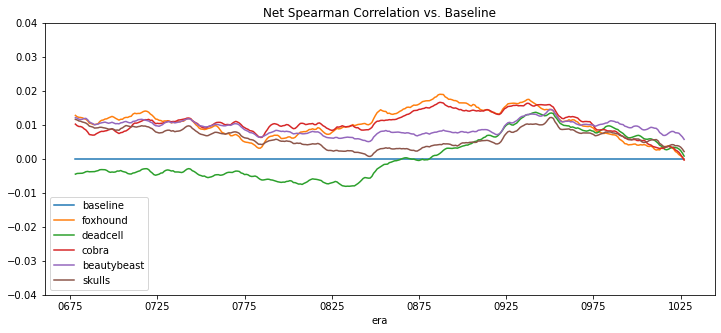

In [32]:
# net spearman vs. baseline for lgbm models
plt.figure(figsize=(12, 5))
for m in lgbm_model_names:
    (lgbm_spearman_corr[m] - lgbm_spearman_corr["baseline"]).rolling(ROLLING_FACTOR).mean().plot()
plt.legend(lgbm_model_names)
plt.ylim(-0.04, 0.04)
plt.title("Net Spearman Correlation vs. Baseline")
plt.show()

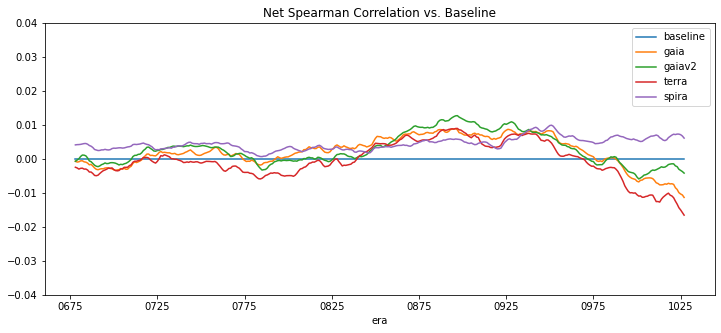

In [33]:
# net spearman vs. baseline for dnn models
plt.figure(figsize=(12, 5))
for m in dnn_model_names:
    (dnn_spearman_corr[m] - dnn_spearman_corr["baseline"]).rolling(ROLLING_FACTOR).mean().plot()
plt.legend(dnn_model_names)
plt.ylim(-0.04, 0.04)
plt.title("Net Spearman Correlation vs. Baseline")
plt.show()

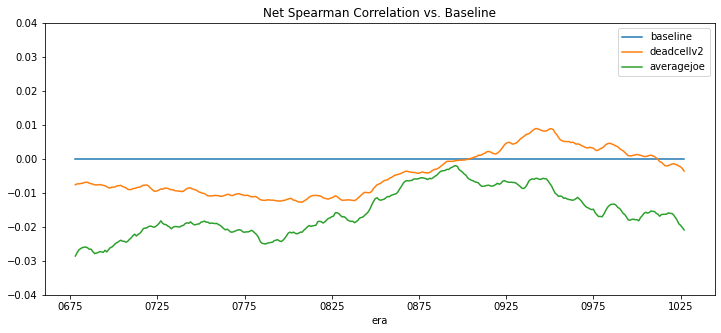

In [34]:
# net spearman vs. baseline for dev models
plt.figure(figsize=(12, 5))
for m in dev_model_names:
    (dev_spearman_corr[m] - dev_spearman_corr["baseline"]).rolling(ROLLING_FACTOR).mean().plot()
plt.legend(dev_model_names)
plt.ylim(-0.04, 0.04)
plt.title("Net Spearman Correlation vs. Baseline")
plt.show()

---
# Get Sharp Ratio by models

In [35]:
# compute sharpe ratio (lgbm models)
lgbm_sharpe_df = pd.concat([
    (lgbm_pearson_corr.mean() / lgbm_pearson_corr.std()),
    (lgbm_spearman_corr.mean() / lgbm_spearman_corr.std())], axis=1)

lgbm_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(lgbm_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.65,0.63
foxhound,1.02,0.99
deadcell,0.64,0.61
cobra,0.96,0.96
beautybeast,0.95,0.90
skulls,0.81,0.78


In [36]:
# compute sharpe ratio (dnn models)
dnn_sharpe_df = pd.concat([
    (dnn_pearson_corr.mean() / dnn_pearson_corr.std()),
    (dnn_spearman_corr.mean() / dnn_spearman_corr.std())], axis=1)

dnn_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(dnn_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.65,0.63
gaia,0.80,0.79
gaiav2,0.97,0.97
terra,0.58,0.59
spira,0.86,0.84


In [37]:
# compute sharpe ratio (dev models)
dev_sharpe_df = pd.concat([
    (dev_pearson_corr.mean() / dev_pearson_corr.std()),
    (dev_spearman_corr.mean() / dev_spearman_corr.std())], axis=1)

dev_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(dev_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.65,0.63
deadcellv2,0.54,0.50
averagejoe,-0.03,-0.02


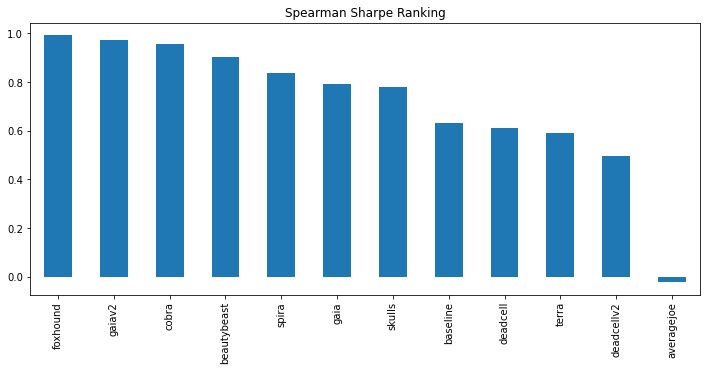

In [38]:
# plot
sharpe_df = pd.concat([lgbm_sharpe_df, dnn_sharpe_df.drop("baseline"), dev_sharpe_df.drop("baseline")])
sharpe_df["sharpe_spearman"].sort_values(ascending=False).plot.bar(
    title="Spearman Sharpe Ranking", 
    figsize=(12, 5)
);

---
# Submit for validation diagnosis

In [39]:
# read model name json file
with open("data/model_names.json", "r") as f:
    model_names = json.load(f)

model_names

{'dh_foxhound': '4d9bcd2c-69cb-4e17-a3f3-a4b2530cbcb8',
 'dh_deadcell': 'df8e47ff-b123-42a1-8145-a55b19be6a99',
 'dh_cobra': 'fe228762-f88a-4d09-9478-d02ae849a58a',
 'dh_beautybeast': '48c649b4-068b-483f-b370-770d55247b8d',
 'dh_skulls': '1296c746-5f1d-44af-a197-7f21e933dac9',
 'dh_desperado': '547bed40-6905-4f13-945d-de77d99e0487',
 'dh_gaia': '23d7378d-a7b4-425b-b67e-77b4bc3d4ccd',
 'dh_terra': '50c76ce7-3e69-47ec-85e4-6dbc6c42969c',
 'dh_spira': '5383643d-e20d-4154-87fd-eaa79587e53f'}

In [40]:
# # single model submission
# model_to_submit = "dh_spira"

# napi.upload_diagnostics(
#     file_path=f"predictions/{model_to_submit}_val_preds.csv",
#     model_id=model_names[f"{model_to_submit}"]
# )

In [41]:
# # submit validation predictions for diagnosis
# for item in model_names.items():
#     print(f"Submitting validation predictions for: {item[0]}...")
#     napi.upload_diagnostics(
#         file_path=f"predictions/{item[0]}_val_preds.csv",
#         model_id=item[1]
#     )